# ARIMA Models

In [1]:
import pandas as pd
pd.set_option('display.width', 76)
pd.set_option('display.max_colwidth', 10)
from statsmodels.tools.sm_exceptions import HessianInversionWarning
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
%matplotlib inline

* ARIMA stands for AutoRegressive Integrated Moving Average
* ARIMA comprises of three different types of models
* ARIMA Models assume a Linear Relationship

## AutoRegressive Models

* When we fit a linear model between past and future obervations of the same variable it is called AutoRegression
* For Autoregressive models to work properly, there should be a good degree of Autocorrelation
* Each past observation forms a predictor
* The formuala for AR models is as follows:

$y_{t} = \alpha + \beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{p} y_{t-p} + \epsilon$

* $y$ are the observations
* $\alpha$ is the estimated constant
* $\beta$ is the estimated coefficient for each predictor 
* $\epsilon$ is normally distributed with zero mean
* $\sigma$ standard deviation (as is expected with linear regression). 
* The number of predictors, or the number of past observations, we include in our model is a parameter of the model and is called the _order_. 
* For example, an autoregressive (AR) model of order 2 only considers the two preceding observations as predictors.  

We'll now import some data as follows:

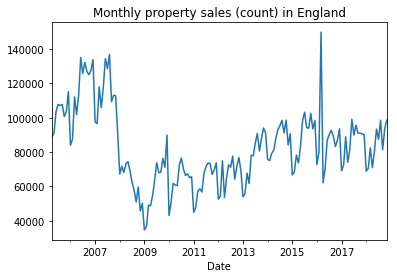

In [2]:
import pandas as pd
from matplotlib.dates import AutoDateLocator
property_sales = pd.read_csv("property_sales_uk.csv", parse_dates=["Date"], index_col=0)
property_sales["England"].plot(title="Monthly property sales (count) in England");

In [3]:
property_sales.head(5)

,England,Scotland,Wales,Northern Ireland
Date,,,,
2005-04-01,88840,10540,4520,3290
2005-05-01,91030,10180,4540,3260
2005-06-01,103700,12120,5050,3790
2005-07-01,107770,12530,5160,3710
2005-08-01,107040,12000,5200,3910


* When using AR models, the mean and variance must be constant (stationary)
* This data is not stationary as there are both trend and seasonal components, which means we must transform our data before we fit the model.
* Additionally it's good practice to drop missing values
* A quick and easy way to do this is to look at the difference between the values using the diff() method

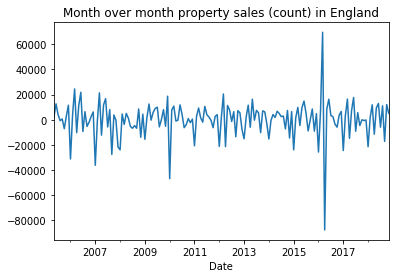

In [4]:
property_sales_diff = property_sales.diff().dropna()
property_sales_diff["England"].plot(title="Month over month property sales (count) in England");

* Having removed the trend and seasonal effects we can now fit an AR model
* We'll use the AR class from statsmodels

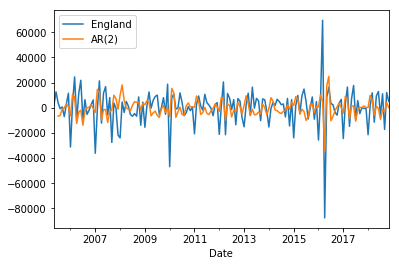

In [6]:
from statsmodels.tsa.ar_model import AR
import numpy as np

# Instancise the model and supply data
ar = AR(property_sales_diff["England"].values)
ar_model = ar.fit(maxlag=2) # Maxlag = order (number of lagged variables to use)

# have to add two NA values at the beginning as these are not part of the fitted values
fitted_values = np.hstack([[np.NaN, np.NaN], ar_model.fittedvalues])
property_sales_diff["AR(2)"] = fitted_values
property_sales_diff[["England", "AR(2)"]].plot();

* We can see from the chart that this is not a particularly good fit
* There could be many reasons for this including:
    - AR model being the wrong choice
    - Not enough AutoCorrelation in the data
    - Most likely is the AR Order (Maxlag)

## Determining the AR Order

* Rather than trial and error, we can use Autocorrelation
* This shows the strength of the relationship between past and current observations

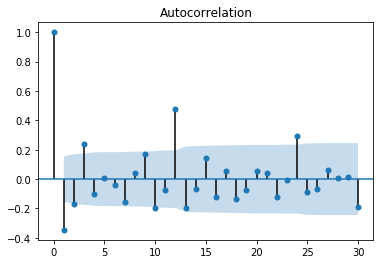

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

acf = plot_acf(property_sales_diff['England'].values, lags=30)

* We can see that there isn't a great deal of autocorrelation here!
* Additionally where there is Autocorrelation present, it can be hard to tell which correlation is 'real' and which is a side effect of a correlation with the series as a whole
* Partial Correlation removes this correlation between the series and the observation
* It does this by looking at the relationship between the observation and a lagged observation, with the intervening observations removed

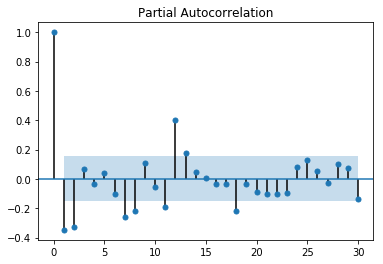

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

pacf = plot_pacf(property_sales_diff['England'].values, lags=30)

* This is better - we can see that there's more statistically significant observations which we can use to predict our time series into the future.
* However there is another way to identify the best order automatically, by supplying an argument to the fit method of the model as follows:

In [14]:
ar_model_opt = ar.fit(ic='aic') # Using Akaike Information Criterion (AIC) as metric
ar_model_opt.k_ar

13

* Here we've passed an argument to the fit method of 'ic'. 
* IC stands for Information Criterion and it's used to select the optimal lag length for the model
* Here we've pass a value of AIC which stands for Akaike Information Criterion, a method for estimating the liklihood of best fit for a model. Other values are 'bic' and 't-stat'
* We can see here that it suggests the best lag as '13' although that's not strictly supported by the plots!

## Moving Average Models

* An alternative to AR is not to use past observations as predictors, but past errors instead.
* This type of model is called a Moving Average (MA) model and the formula is as follows:

𝑦𝑡=𝛼+𝛽1𝜖𝑡−1+𝛽2𝜖𝑡−2+...+𝛽𝑞𝜖𝑡−𝑞 

𝑦  are again the observations,
𝜖  are the errors,
𝛼  is the estimated constant
𝛽  is the estimated coeffient for each error. 

* Simiar to AR models, MA models have an order which controls how many past errors we consider relevant. 
* The statsmodels package does not provide a separate class for fitting MA models. 
* Instead it combines AR models and MA models into the ARMA class and allows you to turn one or the other off.
* A moving average model should not be confused with the moving average used for smoothing a time series. 
* The latter is an aggregation over time while the former is a statistical model for the time series.

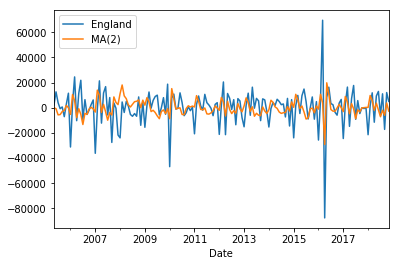

In [15]:
from statsmodels.tsa.arima_model import ARMA

# Note that we're turning the AR part off by the first value in the order argument
arma = ARMA(property_sales_diff["England"].values, order=(0, 2))
arma_model = arma.fit()

property_sales_diff["MA(2)"] = arma_model.fittedvalues
property_sales_diff[["England", "MA(2)"]].plot();

* Again, not a great fit!
* To determine the order of the AR model we looked at peaks in the autocorrelation and partial autocorrelation plots.
* Since we're looking for error and not correlation, we have to do something different:
    - Look for peaks in the partial autocorrelation at lag q 
    - Also look for decreasing correlations after lag q
    - Look for peaks in the autocorrelation at lag q
    - Also look for insignificant values after lag q

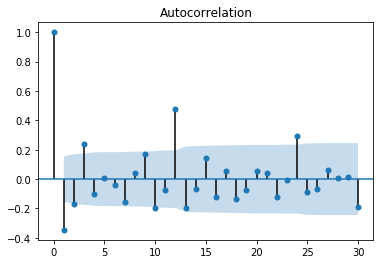

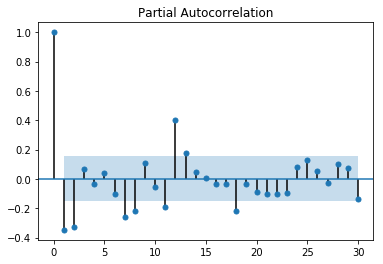

In [17]:
acf = plot_acf(property_sales_diff['England'].values, lags=30)
pacf = plot_pacf(property_sales_diff['England'].values, lags=30)

* In the Autocorrelation we do see a peak at lag 12 but insignificant values after
* However the statistically significant values in the Partial Autocorrelation are spread out
* This suggests that MA isn't a good fit for this data.

## ARIMA

* If neither AR or MA models provide a good fit, we can combine them into an ARMA model.
* However since the Time Series must also be stationary (e.g. not have a seasonal or trend componenet)
* This is what the 'I' means (Integrated)
* The Integrated element is the number of times we need to difference our time series to make it stationary
* In simple terms, an ARIMA model is simply a concatenation of the AR and MA models with the addition that the observations are now differenced one or more times.
* We'll use the ARIMA model class from Statsmodels

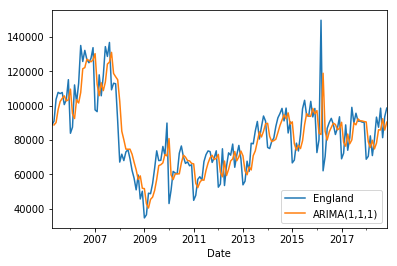

In [18]:
from statsmodels.tsa.arima_model import ARIMA

arima = ARIMA(property_sales["England"].values, order=(1,1,1))
arima_model = arima.fit()
# calling predict with typ='levels' will return predictions in the same unit as the original series
fitted_values = arima_model.predict(typ='levels')

# we again end up with a shorter time series as some values are used to initialize the model
fill_values = [np.NaN]*(len(property_sales)-len(fitted_values))
property_sales["ARIMA(1,1,1)"] = np.hstack([fill_values, fitted_values])
property_sales[["England", "ARIMA(1,1,1)"]].plot();

* The order argument accepts three values:
    - A value for the order of the AR model (p) 
    - The number of times the series must be differenced (d) 
    - The order of the MA model (q).

## Determining the ARIMA Order

* We now need to determine three parameters:
    - The most important is the 'I' - the Integrattion value, or number of times we need to difference the time series to make it stationary
    - The simplest procedure to determine this parameter is to repeatedly difference the time series until it is stationary.
    - We can either do this visually or statistically
    - Statistically is probably more robust, especially if you're new to the process.
    - Statsmodels provides two methods: 
        - adfuller (Augmented Dickey-Fuller)
        - kpss (Kwiatkowski-Phillips-Schmidt-Shin)

* We'll be using the Augmented Dickey-Fuller (adfuller) to perform a hypothesis test.
* Our Hypothesis is that the data is non-stationary (as in it has trend and seasonal componenets).
* The output of the test will be a p-value. This is a measure of the significance of our results
* This is a value between 0 and 1
* In order for us to reject our hypothesis (I.e. saying that the data **is** stationary) and adopt an alternative hypothesis our p-value must be below 0.05.

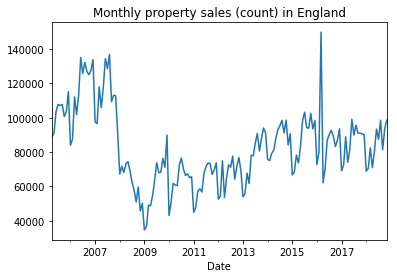

In [23]:
property_sales["England"].plot(title="Monthly property sales (count) in England");

In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
result = adfuller(property_sales["England"].values)
result[1] # p-value

0.09280048697399007

* We already know that this dataset is non stationary so we would expect a p-value greater than 0.05
* Let's diff() the data and try again

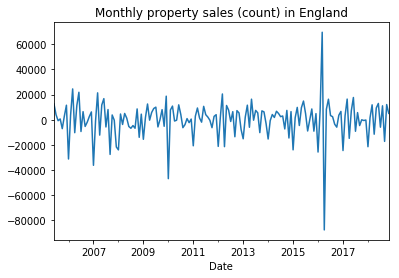

In [28]:
property_sales_diff = property_sales.diff().dropna()
property_sales_diff["England"].plot(title="Monthly property sales (count) in England");

* This is fairly stationary... Will it pass the adfuller test?

In [29]:
result = adfuller(property_sales_diff["England"].values)
result[1]

0.032675476415036396

* It does but therer is still room for improvement!
* Let's take the diff of the diff...

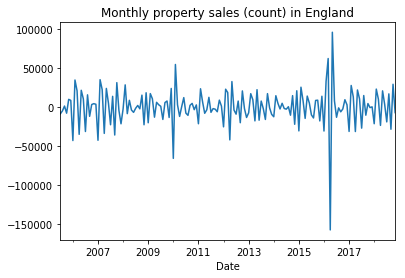

In [36]:
property_sales_diff_two = property_sales_diff.diff().dropna()
property_sales_diff_two["England"].plot(title="Monthly property sales (count) in England");

In [37]:
result = adfuller(property_sales_diff_two["England"].values)
result[1]

9.381166747712361e-17

* As we can see from the number, this is much better!
* As we've taken the difference twice, the order for our Integration element will be 2
* As a next step we could take the differenced series, look at its autocorrelation and partial autocorrelation plot and determine if an AR model or a MA model is more appropriate.
* However Statsmodels has a tool to help us do this automatically as follows:

In [38]:
from statsmodels.tsa.stattools import arma_order_select_ic
result = arma_order_select_ic(property_sales_diff_two["England"].values, ic='aic')
result.aic_min_order

(2, 1)

* Let's plug these values into our model

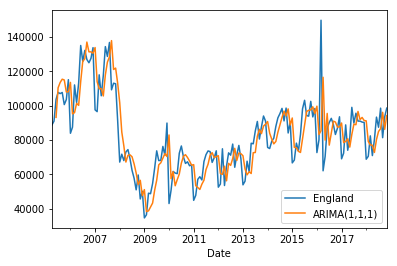

In [41]:
arima = ARIMA(property_sales["England"].values, order=(2,2,1))
arima_model = arima.fit()

# calling predict with typ='levels' will return predictions in the same unit as the original series
fitted_values = arima_model.predict(typ='levels')

# we again end up with a shorter time series as some values are used to initialize the model
fill_values = [np.NaN]*(len(property_sales)-len(fitted_values))
property_sales["ARIMA(1,1,1)"] = np.hstack([fill_values, fitted_values])
property_sales[["England", "ARIMA(1,1,1)"]].plot();

# Box-Jenkins approach

In _Time series analysis:  Forecasting and control_ by George Box and Gwilym Jenkins (1970), the authors proposed a step by step process to create ARIMA models. We have covered some aspects of this approach in previous sections but we will bring them together here.

The various steps are as follows:

## Data analysis and wrangling
The first step is analyse the time series to uncover any outliers or obvious patterns. In this part we also ensure the time series is stationary using a combination of differencing and unit root tests.

## Model creation
The next step is to create an ARIMA model with a specified or estimated order. We can find appropriate values for the order by analysing the autocorrelation and partial autocorrelation plots as we have done before. Alternatively we can use **statsmodels** to automatically find the order for us.

## Estimation of coefficients
After we have decided on the order of the ARIMA model we must estimate its coefficients. This is the job of the `fit` function for each of the classes in **statsmodels**. If we let the package find the order this will automatically give us the estimates as well.

## Diagnostics
Similarly to a linear regression, we must check if our model does not violate any of the underlying assumptions. Most notably we must ensure there is no obvious pattern left in the residuals and they are in fact white noise. We can do this either visually or through statistical methods (such as the Ljung-Box test). If any of the assumptions are not met then it's necessary to refine our model in step 2.


A possible final step is to apply the model to unseen data and generate new forecasts. The out-of-sample error would then provide an estimate of accuracy of the model.